In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np


In [ ]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
location_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(location_plus, ignore_index=True)


In [94]:
dft = df[['PlayResult','PlateLocSide','PlateLocHeight','TaggedPitchType','Outs','Balls','Strikes']]

In [95]:
dft.head()

,PlayResult,PlateLocSide,PlateLocHeight,TaggedPitchType,Outs,Balls,Strikes
0,NaN,0.999072,2.432831,Fastball,0.0,0,0
1,NaN,0.561687,3.857596,Fastball,0.0,0,1
2,NaN,1.501962,1.382880,Slider,0.0,1,1
3,NaN,-0.441733,2.236757,Fastball,0.0,2,1
4,NaN,0.880537,3.901633,Fastball,0.0,2,2


In [96]:
dft = dft.dropna()


In [97]:
dft['PlayResult'].unique()


array(['StrikeoutLooking', 'StrikeoutSwinging', 'Out', 'Single', 'Error',
       'Walk', 'Triple', 'Double', 'HomeRun', 'FieldersChoice',
       'Sacrifice'], dtype=object)

In [98]:
map_data = {
    'StrikeoutLooking': 1,
    'StrikeoutSwinging': 1,
    'Out': 1,
    'Single': 0,
    'Double': 0,
    'Error': 0,
    'Walk': 0,
    'Triple': 0,
    'HomeRun': 0,
    'FieldersChoice': 0,
    'Sacrifice': 0
}

dft['PlayResult'] = dft['PlayResult'].map(map_data)

In [99]:
# One-hot encode TaggedPitchType
pitch_type_dummies = pd.get_dummies(dft['TaggedPitchType'], prefix='PitchType',dtype=int)
dft.drop('TaggedPitchType', axis=1, inplace=True)
# Concatenate with your original DataFrame
dft = pd.concat([dft, pitch_type_dummies], axis=1)

In [100]:
dft.to_csv('dft.csv', index=False)

In [101]:
# X = features (all columns except PlayResult)
X = dft.drop(columns=['PlayResult'])
# y = target (just PlayResult)
y = dft['PlayResult']

In [102]:
features = ['PlateLocSide','PlateLocHeight','Outs','Balls','Strikes']

In [103]:
X.to_csv('test.csv')

In [104]:
def CV():
    k_scores = {}
    for i in range(1,30):
        xba_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xba_model, X, y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

Text(0, 0.5, 'RMSE')

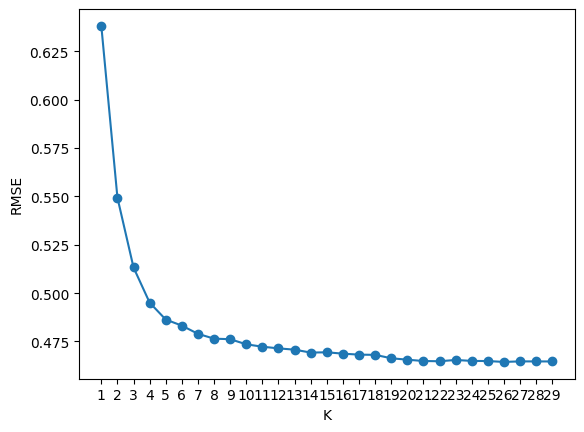

In [105]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,30)])
plt.xlabel("K")
plt.ylabel("RMSE")

In [106]:
location_plus_model = KNeighborsRegressor(n_neighbors = 11)
location_plus_model.fit(X,y)

KNeighborsRegressor(n_neighbors=11)

In [45]:
from itertools import product

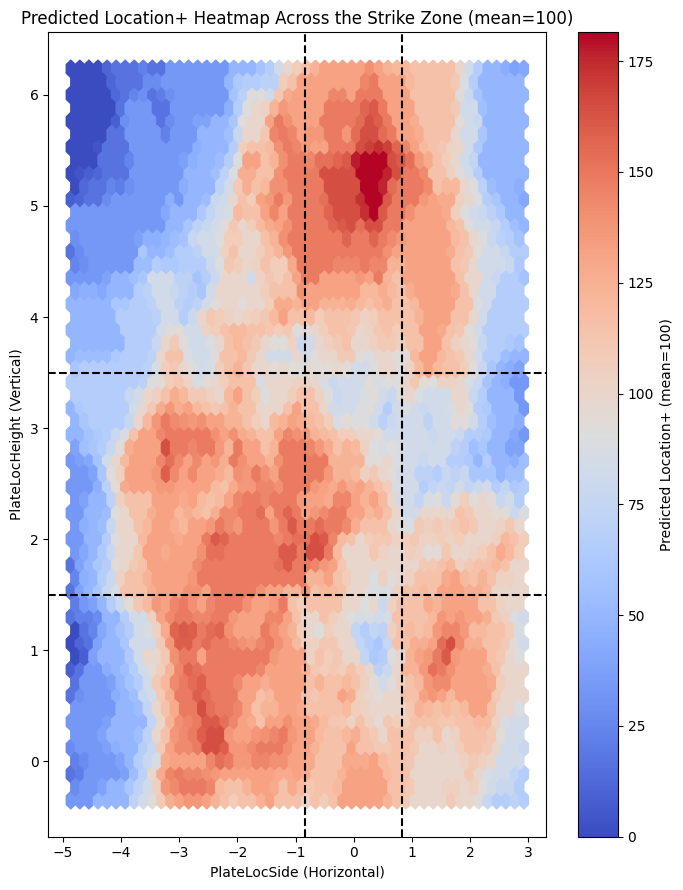

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a grid for PlateLocSide and PlateLocHeight (strike zone)
x = np.linspace(dft['PlateLocSide'].min(), dft['PlateLocSide'].max(), 100)
y = np.linspace(dft['PlateLocHeight'].min(), dft['PlateLocHeight'].max(), 100)
xx, yy = np.meshgrid(x, y)
sim_data = pd.DataFrame({
    'PlateLocSide': xx.ravel(),
    'PlateLocHeight': yy.ravel(),
    'Balls': dft['Balls'].mean(),
    'Strikes': dft['Strikes'].mean(),
    'Outs': dft['Outs'].mean(),
})

# Add pitch type dummies (use mean for all types for an "average" pitch)
for col in ['PitchType_Changeup','PitchType_Curveball','PitchType_Cutter','PitchType_Fastball',
            'PitchType_Knuckleball','PitchType_Sinker','PitchType_Slider','PitchType_Splitter']:
    sim_data[col] = dft[col].mean()

# Reorder columns to match model input
feature_cols = [col for col in dft.columns if col != 'PlayResult']
sim_data = sim_data[feature_cols]

# Predict and scale
sim_data['location_plus'] = location_plus_model.predict(sim_data)
mean_locationplus = sim_data['location_plus'].mean()
sim_data['location_plus_scaled'] = sim_data['location_plus'] * (100 / mean_locationplus)

# Plot hexbin heatmap for Location+ across the strike zone
plt.figure(figsize=(7, 9))
hb = plt.hexbin(
    sim_data['PlateLocSide'],
    sim_data['PlateLocHeight'],
    C=sim_data['location_plus_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("PlateLocSide (Horizontal)")
plt.ylabel("PlateLocHeight (Vertical)")
plt.title("Predicted Location+ Heatmap Across the Strike Zone (mean=100)")
plt.colorbar(hb, label="Predicted Location+ (mean=100)")
plt.axvline(-0.83, color='black', linestyle='--')
plt.axvline(0.83, color='black', linestyle='--')
plt.axhline(1.5, color='black', linestyle='--')
plt.axhline(3.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [108]:
def predict_location_plus(event):
    # Make sure all required features are present
    if all(f in event and not pd.isna(event[f]) for f in features):
        # Predict using the trained model
        pred = location_plus_model.predict([[event[f] for f in features]])[0]
        # Scale so mean is 100 (use your training mean or pass as argument if needed)
        mean_playresult = y.mean()  # or use a fixed value if you want
        return pred * (100 / mean_playresult)
    else:
        return np.nan  # Not enough data to predict

In [117]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [116]:
# event should be a dict or Series with the 7 features
import warnings
warnings.filterwarnings("ignore")
# One-hot encode TaggedPitchType
pitch_type_dummies = pd.get_dummies(kcl_df['TaggedPitchType'], prefix='PitchType',dtype=int)
kcl_df.drop('TaggedPitchType', axis=1, inplace=True)
# Concatenate with your original DataFrame
kcl_df = pd.concat([kcl_df, pitch_type_dummies], axis=1)
kcl_df.to_csv("kcl_location+_data.csv", index=False)
kcl_df['location+'] = kcl_df.apply(predict_location_plus, axis = 1)

kcl_df.to_csv("kcl_location+_data.csv", index=False)


KeyError: 'TaggedPitchType'

In [ ]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("cornbelters_location+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean location+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("location+", "count"),
        location_plus_mean=("location+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["location+_percentile"] = result["location_plus_mean"].rank(pct=True)

# Sort by location+ descending
result = result.sort_values("location_plus_mean", ascending=False)

# Show the result
result.to_csv("cornbelters_location+_pitcher_ranking.csv", index=False)

In [ ]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("kcl_location+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean location+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("location+", "count"),
        location_plus_mean=("location+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["location+_percentile"] = result["location_plus_mean"].rank(pct=True)

# Sort by location+ descending
result = result.sort_values("location_plus_mean", ascending=False)

# Show the result
result.to_csv("kcl_location+_pitcher_ranking.csv", index=False)

In [86]:
import pickle

In [ ]:
with open("location_plus_model.pkl", "wb") as f:
    pickle.dump(location_plus_model, f)

In [88]:
y.mean()

np.float64(0.5843009753831863)